<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix



#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time

In [3]:
%%capture
!wget https://www.dropbox.com/s/ja56cvf3x4mkf1t/modelnet10_voxelized_32.npz

In [4]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          tmp = np.load("modelnet10_voxelized_32.npz")
          self.data = tmp["X_train"]
          self.label = tmp["Y_train"]
          del tmp
      else:
          tmp = np.load("modelnet10_voxelized_32.npz")
          self.data = tmp["X_test"]
          self.label = tmp["Y_test"]
          del tmp
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        #flip x
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=0)
        
        #flip y
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        
        voxels = rotate(voxels, axes=(0, 1), angle=angle, cval=0.0, reshape=False)
        
        
        return voxels.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [9]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('batch2', torch.nn.BatchNorm3d(32)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x


In [13]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

def blue(x): return '\033[94m' + x + '\033[0m'

train_ds = VoxelDataset(train=True)
test_ds = VoxelDataset(train=False)
train_dataloader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=32)

pred_conf, y_conf = [], []                                                           

train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []
train_accuracy = Accuracy(task='multiclass', num_classes=10)
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

model = VoxNet()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = F.cross_entropy
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs = 50
best_val = np.inf

num_batch = len(train_ds) / 32
print(num_batch)

total_time = time.time()

for epoch in range(epochs):
    t = time.time()

    train_l = 0
    test_l = 0

    temp_correct = 0
    temp_testset = 0
    temp_correct_test = 0
    temp_testset_test = 0
    train_loss = []                                                         #track training loss
    test_loss = []
    model.train()
    iterator = tqdm(enumerate(train_dataloader, 0))
    for i, data in iterator:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        pred = model(inputs)  # torch.Size([256, 10])
        loss = F.cross_entropy(pred,labels)
        train_loss.append(loss.cpu().data)
        acc = train_accuracy(torch.argmax(pred, 1).cpu(), labels.cpu()) 

        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.cpu().data}")
        #train_l += loss.cpu().data
        
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(labels.data).cpu().sum()
        
        temp_correct += correct.item()
        temp_testset += inputs.size()[0]

    
    with torch.no_grad():
      model.eval()
      for j, sample in tqdm(enumerate(test_dataloader, 0)):    
          inputs_test, labels_test = sample[0], sample[1]
          inputs_test = inputs_test.to(device)
          labels_test = labels_test.to(device)
          inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
          
          pred_test = model(inputs_test)
          loss_test = F.cross_entropy(pred_test, labels_test)
          test_loss.append(loss_test.cpu().data)
          valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
          pred_choice_test = pred_test.data.max(1)[1]

          #test_l += loss_test.cpu().data

          correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
          pred_conf.append(torch.argmax(pred_test, 1))
          y_conf.append(labels_test)
          
          temp_correct_test += correct_test.item()
          temp_testset_test += inputs_test.size()[0]

    #compute confusion matrix
    a = torch.cat(pred_conf).cpu()
    b = torch.cat(y_conf).cpu()
    confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
    conf_matrix = confmat(a, b)
    conf_matrix = torch.round(conf_matrix, decimals=2)

    # total accuracy over all batches
    total_train_accuracy = train_accuracy.compute()
    total_valid_accuracy = valid_accuracy.compute()
    train_accuracy.reset()
    valid_accuracy.reset()
           
    #track loss and acc for plotting
    train_loss_history.append(torch.mean(torch.tensor(train_loss)))
    valid_loss_history.append(torch.mean(torch.tensor(test_loss)))
    train_acc_history.append(total_train_accuracy)
    valid_acc_history.append(total_valid_accuracy)
    history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
               "test_loss": torch.tensor(valid_loss_history), "test_acc": torch.tensor(valid_acc_history)}

    elapsed_time_epoch = time.time() - t
    tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, epochs)
    tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
    tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
    tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
    print(tmp0, tmp1, tmp2, tmp3, sep="\n")           
    
    #print("epoch %d: train accuracy %f" % (epoch, temp_correct / float(temp_testset)))
    #print("epoch %d: test accuracy %f" % (epoch+1, temp_correct_test / float(temp_testset_test)))

    


total_correct = 0
total_testset = 0

model.eval()
for i, data in tqdm(enumerate(test_dataloader, 0)):
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.float()  # 转float, torch.Size([256, 1, 32, 32, 32])

    
    pred = model(inputs)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(labels.data).cpu().sum()
    total_correct += correct.item()
    total_testset += inputs.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))



124.71875


Train loss: 0.5450330376625061: : 124it [01:16,  1.63it/s]
29it [00:08,  3.42it/s]


epoch:  1 / 50
time: 84.81 seconds
train-loss: 1.09, train-acc: 63.18%
valid-loss: 0.79, valid-acc: 72.36%



Train loss: 0.354984849691391: : 124it [01:17,  1.59it/s]
29it [00:08,  3.38it/s]


epoch:  2 / 50
time: 86.47 seconds
train-loss: 0.63, train-acc: 79.41%
valid-loss: 0.62, valid-acc: 79.52%



Train loss: 0.4532097578048706: : 124it [01:17,  1.60it/s]
29it [00:08,  3.44it/s]


epoch:  3 / 50
time: 86.07 seconds
train-loss: 0.50, train-acc: 83.80%
valid-loss: 0.51, valid-acc: 84.69%



Train loss: 0.37794527411460876: : 124it [01:16,  1.61it/s]
29it [00:08,  3.35it/s]


epoch:  4 / 50
time: 85.60 seconds
train-loss: 0.42, train-acc: 86.44%
valid-loss: 0.50, valid-acc: 82.93%



Train loss: 0.5092144012451172: : 124it [01:18,  1.57it/s]
29it [00:08,  3.38it/s]


epoch:  5 / 50
time: 87.61 seconds
train-loss: 0.38, train-acc: 87.73%
valid-loss: 0.47, valid-acc: 84.36%



Train loss: 0.30839723348617554: : 124it [01:16,  1.61it/s]
29it [00:08,  3.40it/s]


epoch:  6 / 50
time: 85.40 seconds
train-loss: 0.34, train-acc: 89.14%
valid-loss: 0.45, valid-acc: 84.03%



Train loss: 0.3646879494190216: : 124it [01:19,  1.56it/s]
29it [00:08,  3.39it/s]


epoch:  7 / 50
time: 88.17 seconds
train-loss: 0.32, train-acc: 89.44%
valid-loss: 0.44, valid-acc: 85.13%



Train loss: 0.17090781033039093: : 124it [01:16,  1.62it/s]
29it [00:08,  3.34it/s]


epoch:  8 / 50
time: 85.16 seconds
train-loss: 0.29, train-acc: 89.94%
valid-loss: 0.44, valid-acc: 85.79%



Train loss: 0.19415715336799622: : 124it [01:17,  1.59it/s]
29it [00:08,  3.37it/s]


epoch:  9 / 50
time: 86.41 seconds
train-loss: 0.28, train-acc: 90.02%
valid-loss: 0.41, valid-acc: 86.34%



Train loss: 0.15107464790344238: : 124it [01:18,  1.58it/s]
29it [00:08,  3.39it/s]


epoch: 10 / 50
time: 86.89 seconds
train-loss: 0.26, train-acc: 91.51%
valid-loss: 0.42, valid-acc: 86.34%



Train loss: 0.16520516574382782: : 124it [01:17,  1.61it/s]
29it [00:08,  3.40it/s]


epoch: 11 / 50
time: 85.63 seconds
train-loss: 0.25, train-acc: 90.95%
valid-loss: 0.41, valid-acc: 86.34%



Train loss: 0.20604905486106873: : 124it [01:19,  1.57it/s]
29it [00:08,  3.37it/s]


epoch: 12 / 50
time: 87.66 seconds
train-loss: 0.23, train-acc: 92.44%
valid-loss: 0.41, valid-acc: 87.22%



Train loss: 0.33724749088287354: : 124it [01:16,  1.62it/s]
29it [00:08,  3.41it/s]


epoch: 13 / 50
time: 84.89 seconds
train-loss: 0.22, train-acc: 92.52%
valid-loss: 0.39, valid-acc: 86.89%



Train loss: 0.18317613005638123: : 124it [01:18,  1.57it/s]
29it [00:08,  3.42it/s]


epoch: 14 / 50
time: 87.27 seconds
train-loss: 0.21, train-acc: 92.69%
valid-loss: 0.41, valid-acc: 86.78%



Train loss: 0.27761951088905334: : 124it [01:16,  1.63it/s]
29it [00:08,  3.42it/s]


epoch: 15 / 50
time: 84.81 seconds
train-loss: 0.21, train-acc: 92.84%
valid-loss: 0.41, valid-acc: 87.22%



Train loss: 0.1820666640996933: : 124it [01:17,  1.60it/s]
29it [00:09,  3.09it/s]


epoch: 16 / 50
time: 86.85 seconds
train-loss: 0.20, train-acc: 93.20%
valid-loss: 0.40, valid-acc: 87.44%



Train loss: 0.06728336960077286: : 124it [01:17,  1.60it/s]
29it [00:08,  3.32it/s]


epoch: 17 / 50
time: 86.44 seconds
train-loss: 0.19, train-acc: 93.80%
valid-loss: 0.40, valid-acc: 87.44%



Train loss: 0.3179111182689667: : 124it [01:17,  1.60it/s]
29it [00:08,  3.34it/s]


epoch: 18 / 50
time: 86.20 seconds
train-loss: 0.19, train-acc: 94.23%
valid-loss: 0.37, valid-acc: 87.89%



Train loss: 0.20996809005737305: : 124it [01:20,  1.55it/s]
29it [00:08,  3.36it/s]


epoch: 19 / 50
time: 88.80 seconds
train-loss: 0.18, train-acc: 93.47%
valid-loss: 0.42, valid-acc: 85.79%



Train loss: 0.06947875767946243: : 124it [01:17,  1.59it/s]
29it [00:08,  3.32it/s]


epoch: 20 / 50
time: 86.68 seconds
train-loss: 0.18, train-acc: 93.65%
valid-loss: 0.39, valid-acc: 87.11%



Train loss: 0.11643967777490616: : 124it [01:20,  1.54it/s]
29it [00:08,  3.32it/s]


epoch: 21 / 50
time: 89.18 seconds
train-loss: 0.18, train-acc: 93.75%
valid-loss: 0.37, valid-acc: 87.56%



Train loss: 0.09436290711164474: : 124it [01:17,  1.60it/s]
29it [00:08,  3.27it/s]


epoch: 22 / 50
time: 86.40 seconds
train-loss: 0.17, train-acc: 94.33%
valid-loss: 0.40, valid-acc: 87.56%



Train loss: 0.25176915526390076: : 124it [01:18,  1.57it/s]
29it [00:08,  3.32it/s]


epoch: 23 / 50
time: 87.60 seconds
train-loss: 0.15, train-acc: 94.61%
valid-loss: 0.44, valid-acc: 86.23%



Train loss: 0.247516468167305: : 124it [01:18,  1.58it/s]
29it [00:08,  3.31it/s]


epoch: 24 / 50
time: 87.09 seconds
train-loss: 0.15, train-acc: 94.61%
valid-loss: 0.39, valid-acc: 88.55%



Train loss: 0.28636547923088074: : 124it [01:17,  1.60it/s]
29it [00:09,  3.16it/s]


epoch: 25 / 50
time: 86.62 seconds
train-loss: 0.15, train-acc: 94.38%
valid-loss: 0.39, valid-acc: 87.44%



Train loss: 0.1756979376077652: : 124it [01:17,  1.60it/s]
29it [00:08,  3.41it/s]


epoch: 26 / 50
time: 86.11 seconds
train-loss: 0.15, train-acc: 94.63%
valid-loss: 0.39, valid-acc: 87.33%



Train loss: 0.0910169705748558: : 124it [01:16,  1.63it/s]
29it [00:08,  3.39it/s]


epoch: 27 / 50
time: 84.76 seconds
train-loss: 0.15, train-acc: 94.88%
valid-loss: 0.37, valid-acc: 88.44%



Train loss: 0.148439422249794: : 124it [01:17,  1.60it/s]
29it [00:08,  3.39it/s]


epoch: 28 / 50
time: 85.91 seconds
train-loss: 0.14, train-acc: 95.36%
valid-loss: 0.43, valid-acc: 86.56%



Train loss: 0.04917287826538086: : 124it [01:16,  1.63it/s]
29it [00:08,  3.39it/s]


epoch: 29 / 50
time: 84.88 seconds
train-loss: 0.14, train-acc: 94.78%
valid-loss: 0.38, valid-acc: 87.67%



Train loss: 0.30159640312194824: : 124it [01:17,  1.59it/s]
29it [00:08,  3.36it/s]


epoch: 30 / 50
time: 86.59 seconds
train-loss: 0.14, train-acc: 94.86%
valid-loss: 0.42, valid-acc: 87.67%



Train loss: 0.1658400148153305: : 124it [01:16,  1.61it/s]
29it [00:08,  3.39it/s]


epoch: 31 / 50
time: 85.50 seconds
train-loss: 0.12, train-acc: 95.61%
valid-loss: 0.41, valid-acc: 88.11%



Train loss: 0.12488455325365067: : 124it [01:16,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 32 / 50
time: 86.18 seconds
train-loss: 0.12, train-acc: 95.64%
valid-loss: 0.44, valid-acc: 87.11%



Train loss: 0.19745920598506927: : 124it [01:15,  1.63it/s]
29it [00:08,  3.40it/s]


epoch: 33 / 50
time: 84.42 seconds
train-loss: 0.13, train-acc: 95.72%
valid-loss: 0.41, valid-acc: 87.89%



Train loss: 0.13874132931232452: : 124it [01:16,  1.63it/s]
29it [00:08,  3.42it/s]


epoch: 34 / 50
time: 84.78 seconds
train-loss: 0.13, train-acc: 95.29%
valid-loss: 0.40, valid-acc: 87.33%



Train loss: 0.03572186082601547: : 124it [01:17,  1.60it/s]
29it [00:08,  3.43it/s]


epoch: 35 / 50
time: 85.75 seconds
train-loss: 0.11, train-acc: 95.74%
valid-loss: 0.39, valid-acc: 88.00%



Train loss: 0.17429335415363312: : 124it [01:16,  1.62it/s]
29it [00:08,  3.39it/s]


epoch: 36 / 50
time: 84.95 seconds
train-loss: 0.12, train-acc: 95.64%
valid-loss: 0.43, valid-acc: 86.45%



Train loss: 0.06452849507331848: : 124it [01:17,  1.59it/s]
29it [00:08,  3.37it/s]


epoch: 37 / 50
time: 86.57 seconds
train-loss: 0.12, train-acc: 95.77%
valid-loss: 0.41, valid-acc: 88.33%



Train loss: 0.0666923001408577: : 124it [01:16,  1.62it/s]
29it [00:08,  3.39it/s]


epoch: 38 / 50
time: 84.99 seconds
train-loss: 0.11, train-acc: 96.19%
valid-loss: 0.41, valid-acc: 88.11%



Train loss: 0.1542593240737915: : 124it [01:16,  1.63it/s]
29it [00:09,  2.96it/s]


epoch: 39 / 50
time: 85.87 seconds
train-loss: 0.11, train-acc: 96.02%
valid-loss: 0.44, valid-acc: 88.11%



Train loss: 0.0265820175409317: : 124it [01:15,  1.63it/s]
29it [00:08,  3.38it/s]


epoch: 40 / 50
time: 84.50 seconds
train-loss: 0.12, train-acc: 95.67%
valid-loss: 0.40, valid-acc: 87.33%



Train loss: 0.12560176849365234: : 124it [01:16,  1.63it/s]
29it [00:08,  3.36it/s]


epoch: 41 / 50
time: 84.97 seconds
train-loss: 0.12, train-acc: 95.74%
valid-loss: 0.42, valid-acc: 87.78%



Train loss: 0.12583620846271515: : 124it [01:17,  1.59it/s]
29it [00:08,  3.34it/s]


epoch: 42 / 50
time: 86.69 seconds
train-loss: 0.11, train-acc: 96.02%
valid-loss: 0.44, valid-acc: 87.00%



Train loss: 0.1236647367477417: : 124it [01:16,  1.63it/s]
29it [00:08,  3.37it/s]


epoch: 43 / 50
time: 84.89 seconds
train-loss: 0.10, train-acc: 96.14%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.0111888712272048: : 124it [01:17,  1.60it/s]
29it [00:08,  3.37it/s]


epoch: 44 / 50
time: 85.92 seconds
train-loss: 0.10, train-acc: 96.14%
valid-loss: 0.42, valid-acc: 86.78%



Train loss: 0.19910088181495667: : 124it [01:15,  1.64it/s]
29it [00:08,  3.41it/s]


epoch: 45 / 50
time: 84.32 seconds
train-loss: 0.10, train-acc: 96.32%
valid-loss: 0.44, valid-acc: 87.33%



Train loss: 0.04077708721160889: : 124it [01:17,  1.61it/s]
29it [00:10,  2.86it/s]


epoch: 46 / 50
time: 87.28 seconds
train-loss: 0.09, train-acc: 96.50%
valid-loss: 0.45, valid-acc: 87.67%



Train loss: 0.06730352342128754: : 124it [01:17,  1.60it/s]
29it [00:08,  3.37it/s]


epoch: 47 / 50
time: 86.20 seconds
train-loss: 0.10, train-acc: 96.12%
valid-loss: 0.44, valid-acc: 88.11%



Train loss: 0.0865897461771965: : 124it [01:17,  1.61it/s]
29it [00:08,  3.37it/s]


epoch: 48 / 50
time: 85.66 seconds
train-loss: 0.09, train-acc: 96.62%
valid-loss: 0.41, valid-acc: 87.78%



Train loss: 0.05719397962093353: : 124it [01:18,  1.58it/s]
29it [00:08,  3.36it/s]


epoch: 49 / 50
time: 87.29 seconds
train-loss: 0.09, train-acc: 96.30%
valid-loss: 0.38, valid-acc: 88.77%



Train loss: 0.032113756984472275: : 124it [01:17,  1.60it/s]
29it [00:08,  3.34it/s]


epoch: 50 / 50
time: 86.12 seconds
train-loss: 0.09, train-acc: 96.70%
valid-loss: 0.41, valid-acc: 88.00%



29it [00:08,  3.34it/s]

final accuracy 0.8821585903083701


Text(0.5, 1.0, 'Confusion Matrix')

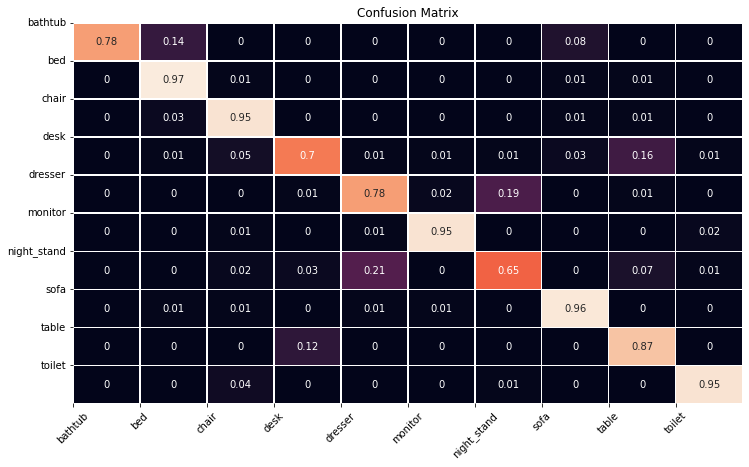

In [14]:
fig=plt.figure(figsize = (12,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)
plt.title("Confusion Matrix")
        

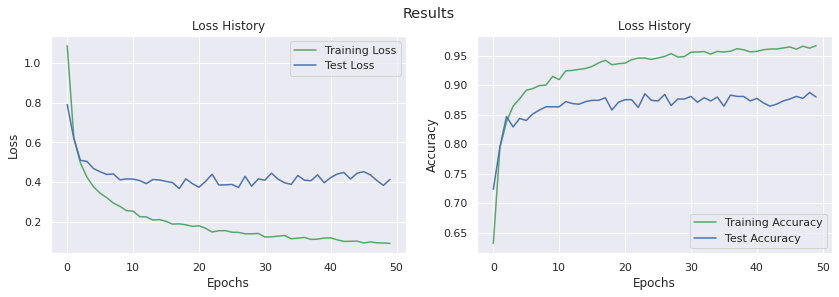

In [15]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

eps = range(0, len(history["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Results')
       
ax[0].plot(eps, smooth(history["train_loss"].cpu()), 'g', label='Training Loss')
ax[0].plot(eps, smooth(history["test_loss"].cpu()), 'b', label='Test Loss')
ax[0].set_title('Loss History')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()
        
ax[1].plot(eps, smooth(history["train_acc"].cpu()), 'g', label='Training Accuracy')
ax[1].plot(eps, smooth(history["test_acc"].cpu()), 'b', label='Test Accuracy')
ax[1].set_title('Loss History')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()